In [1]:
!nvidia-smi

Sat Nov 25 02:26:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     Off | 00000000:0B:00.0  On |                  Off |
| 32%   43C    P8              36W / 480W |    822MiB / 24564MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from src.utils import set_seed

set_seed(42)

In [3]:
import glob

#TODO: Если не созданы тайлы, то надо запустить src/preprocessing/tile_generating.py

tiles_folders = glob.glob("../data/digital_leaders/tiles/*")
len(tiles_folders)

21

In [4]:
from sklearn.model_selection import train_test_split
import os

train_folders, val_folders = train_test_split(tiles_folders, test_size=0.2)
print(f"Train: {[os.path.basename(x) for x in train_folders]}")
print(f"Val: {[os.path.basename(x) for x in val_folders]}")
train_paths = []
val_paths = []
for folder in train_folders:
    train_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
for folder in val_folders:
    val_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
len(train_paths), len(val_paths)

Train: ['train_image_019', 'train_image_010', 'train_image_006', 'train_image_007', 'train_image_013', 'train_image_000', 'train_image_020', 'train_image_015', 'train_image_017', 'train_image_002', 'train_image_011', 'train_image_016', 'train_image_008', 'train_image_003', 'train_image_014', 'train_image_018']
Val: ['train_image_004', 'train_image_012', 'train_image_001', 'train_image_005', 'train_image_009']


(2338, 1084)

In [5]:
from torch.utils.data import Dataset
import cv2
import numpy as np


class TileDataset(Dataset):
    def __init__(self, paths, transforms=None):
        self.paths = paths
        self.transforms = transforms

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = path.replace("images", "masks").replace("tile_", "mask_tile_")
        mask = cv2.imread(mask_path)[:, :, 0]
        mask = np.expand_dims(mask, axis=-1)
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

train_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = TileDataset(train_paths, train_transforms)
val_dataset = TileDataset(val_paths, val_transforms)

In [8]:
import torch


def chw2hwc(image: torch.Tensor) -> torch.Tensor:
    return image.permute(1, 2, 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


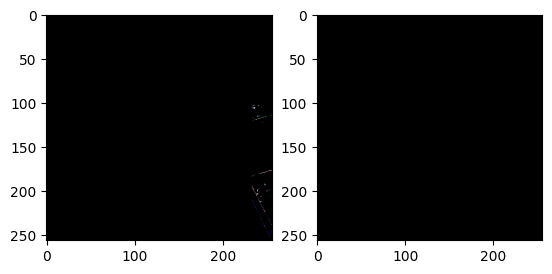

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


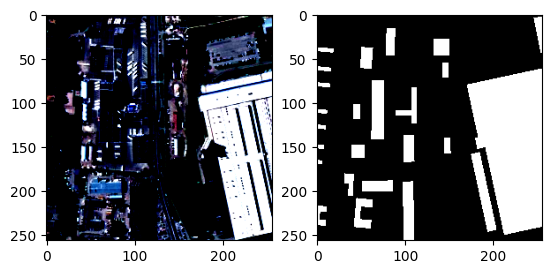

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


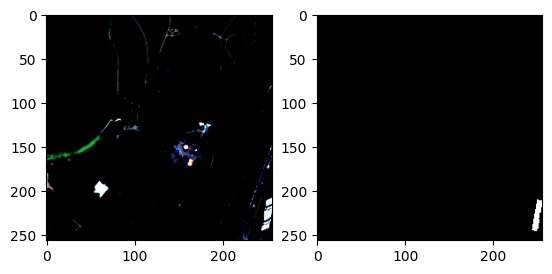

In [9]:
import matplotlib.pyplot as plt

k = 0
for image, mask in train_dataset:
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(chw2hwc(image))
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

    k += 1
    if k == 3:
        break

In [10]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True
)

In [11]:
from torchgeo.models import ResNet50_Weights
import segmentation_models_pytorch as smp
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = smp.Unet(encoder_name="resnet50", encoder_weights=None,
                 in_channels=weights.meta["in_chans"], classes=1,
                 activation="sigmoid")
model.encoder.load_state_dict(weights.get_state_dict(), strict=False)
model.to(device)

cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
from src.modelling.metrics import DiceMetric, IoULoss

criterion = IoULoss()
metric = DiceMetric()

In [13]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

epochs = 10
lr = 3e-4
optimizer = Adam(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=epochs,
                       steps_per_epoch=len(train_loader))

In [14]:
from src.modelling.train import run

run(model=model, train_loader=train_loader, val_loader=val_loader,
    criterion=criterion, metric=metric, optimizer=optimizer,
    scheduler=scheduler, epochs=epochs, device=device,
    save_name=f"{model.__class__.__name__}_rn50_MOCO.pth",
    weights_path="../artifacts/weights")

Epoch #1


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.219956 | 0.900356


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.333514 | 0.877812

Epoch #2


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.412551 | 0.832349


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.427588 | 0.807010

Epoch #3


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.532556 | 0.702042


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.563704 | 0.639584
Epoch #4


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.580733 | 0.606449


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.612177 | 0.569265

Epoch #5


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.606422 | 0.569971


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.633010 | 0.541246

Epoch #6


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.629957 | 0.543167


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.627773 | 0.543400

Epoch #7


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.642781 | 0.528021


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.644814 | 0.525227
Epoch #8


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.654369 | 0.515011


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.652842 | 0.515492
Epoch #9


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.660450 | 0.508268


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.647881 | 0.520878

Epoch #10


  0%|          | 0/147 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.663249 | 0.503474


  0%|          | 0/68 [00:00<?, ?it/s]

Val: 0.649680 | 0.518756


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      